In [1]:
import os
import pickle
import itertools
from datetime import datetime
from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

from sklearn.metrics import mean_absolute_error

os.chdir("C:/2023_11-PTSFC")
import model_train as model_train
import data_prepro as data_prepro
import model_eval as model_eval

In [171]:
import importlib
importlib.reload(model_eval)

<module 'model_eval' from 'C:\\2023_11-PTSFC\\model_eval.py'>

### Import

In [3]:
# os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# get data
# df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))

# Read data from file with specified data types
df_energy = pd.read_csv("data/2015-01-01_2024-02-21_energy.csv", index_col=0, parse_dates=[0])
df_energy['timestamp_CET'] = pd.to_datetime(df_energy['timestamp_CET'], utc=True).dt.tz_convert('CET')
print(df_energy.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80136 entries, 2014-12-31 23:00:00+00:00 to 2024-02-21 22:00:00+00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  80136 non-null  datetime64[ns, CET]
 1   gesamt         80136 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


In [145]:
# Read Pickle File of Scores
with open("2024-03-29_05-34-22 mstl/eval.pickle", "rb") as f:
    scores_dict = pickle.load(f)

# Read Pickle File of Fcasts
with open("2024-03-29_05-34-22 mstl/fcasts.pickle", "rb") as f:
    fcasts_dict = pickle.load(f)

### All Models Evaluation

In [5]:
input_dict = scores_dict
all_weekly_df_dict = {}

for week_key, weekly_scores in input_dict.items():

    weekly_scores_df_out = pd.DataFrame(index=list(input_dict[list(input_dict.keys())[0]].keys()),
                                    columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 
                                             'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975'])

    for key, model_scores in weekly_scores.items():

        weekly_scores_df_out.loc[key, 'avg_qscore'] = model_scores.values.mean()
        weekly_scores_df_out.loc[key, 'avg_qscore_0.025'] = model_scores.mean(axis=0).iloc[0]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.25'] = model_scores.mean(axis=0).iloc[1]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.5'] = model_scores.mean(axis=0).iloc[2]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.75'] = model_scores.mean(axis=0).iloc[3]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.975'] = model_scores.mean(axis=0).iloc[4]
        
    all_weekly_df_dict[week_key] = weekly_scores_df_out

# sum all dataframes in dict (all_weekly_df_dict) and take mean
weekly_scores_df_out = pd.concat(all_weekly_df_dict.values())
weekly_scores_df_out = weekly_scores_df_out.groupby(weekly_scores_df_out.index).mean()
weekly_scores_df_out = weekly_scores_df_out.sort_values(by='avg_qscore', ascending=True)
# highlight min value in each col
display(weekly_scores_df_out.style.highlight_min(color = 'yellow', axis = 0))

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975
mstl_0.5,0.752816,0.187625,1.035197,1.311123,1.024416,0.205716
mstl_0.25,0.763535,0.207902,1.076758,1.315045,1.009274,0.208693
mstl_4,0.793431,0.236671,1.077169,1.339435,1.086914,0.226968
mstl_3,0.794864,0.237304,1.078629,1.338937,1.090133,0.229319
mstl_1.5,0.798860,0.238826,1.083723,1.338937,1.098139,0.234672
mstl_2,0.799886,0.239668,1.084982,1.338937,1.100006,0.235837
mstl_1,0.800466,0.241344,1.084623,1.322330,1.110011,0.244023


### Extra Horizon Analysis from Fcasts

In [153]:
def eval_all_ensembles_detailed(ens_size, all_models, fcasts_dict_all):

    # Generate all possible combinations
    # ens_size = 1
    combis = list(itertools.combinations(all_models, ens_size))
    # filter out all ensembles with repeating models
    combis = [combi for combi in combis if len(set(combi)) == ens_size]
    print(len(combis))

    # Define the start and end dates
    start_date = pd.Timestamp('2023-11-15')
    end_date = pd.Timestamp('2024-02-14')

    # Generate a list of weekly dates in UTC
    fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()

    res_dict = {}

    # Iterate over the forecast dates
    for fcast_idx, fcast_date in enumerate(fcast_dates_cet):

        # print('= '*30)
        print(f"Forecasting for week starting from {fcast_date} ...")

        # = = = = = = = = = = = = = 
        # generate prediction timestamps based on t0 = following thursday 00:00
        # = = = = = = = = = = = = = 

        # Calculate the Thursday and Wednesday of the week
        t_wednesday = pd.Timestamp(fcast_date).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize('CET')
        subm_timestamps = [(t_wednesday + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
        # print(f"Submission timestamps = {subm_timestamps[0]} to {subm_timestamps[-1]}")

        weekly_fcasts = fcasts_dict_all[fcast_date]

        # = = = = = = = = = = = = = 
        # Evaluation based on submission timestamps
        # = = = = = = = = = = = = = 

        # get actual values at every submission timestamp
        df_energy_eval = df_energy.loc[df_energy['timestamp_CET'].isin(subm_timestamps)].copy()

        weekly_model_scores_dict = {}

        for combi_idx, combi in enumerate(combis):

            # calculate ensemble between the preds of the models in the current combination
            pred_list = [weekly_fcasts[model] for model in combi]
            new_name = f"ens | {', '.join(combi)}" if ens_size > 1 else combi[0]

            # Ignore timestamp_CET column and take the average of the quantiles
            pred_vals_list = [pred.iloc[:, 1:].copy() for pred in pred_list]

            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].copy()
            ens_pred_df.iloc[:, 1:] = sum(pred_vals_list) / len(pred_vals_list)
            df_scores = model_eval.eval_fcast_qscore(ens_pred_df, df_energy_eval, subm_timestamps, quantiles)

            subm_df = ens_pred_df.loc[ens_pred_df['timestamp_CET'].isin(subm_timestamps)]
            # Save the last row of the scores dataframe to final output
            df_scores['coverage_50'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 2], subm_df.iloc[:, 4])
            df_scores['coverage_95'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 1], subm_df.iloc[:, 5])
            df_scores['mae_q0.5'] = np.abs(subm_df['q 0.500'] - df_energy_eval['gesamt'])

            weekly_model_scores_dict[new_name] = df_scores

        res_dict[fcast_date] = weekly_model_scores_dict

    return res_dict


In [173]:
all_models = list(fcasts_dict['2023-11-15'].keys())
res_dict_detailed = eval_all_ensembles_detailed(1, all_models, fcasts_dict)

# res_df_1 = pd.concat(res_dict_1.values())
# res_df_1 = res_df_1.groupby(res_df_1.index).mean() # .sort_values(by='avg_qscore', ascending=True)
# # export to csv
# # res_df_1.to_csv("2024_03_28 single model scores.csv")
# display(res_df_1.style.highlight_min(color = 'yellow', axis=0))

7
Forecasting for week starting from 2023-11-15 ...
Forecasting for week starting from 2023-11-22 ...
Forecasting for week starting from 2023-11-29 ...
Forecasting for week starting from 2023-12-06 ...
Forecasting for week starting from 2023-12-13 ...
Forecasting for week starting from 2023-12-20 ...
Forecasting for week starting from 2023-12-27 ...
Forecasting for week starting from 2024-01-03 ...
Forecasting for week starting from 2024-01-10 ...
Forecasting for week starting from 2024-01-17 ...
Forecasting for week starting from 2024-01-24 ...
Forecasting for week starting from 2024-01-31 ...
Forecasting for week starting from 2024-02-07 ...
Forecasting for week starting from 2024-02-14 ...


In [190]:
input_dict = res_dict_detailed.copy()
all_models = input_dict['2023-11-15'].keys()

model_scores_entire_period_dict = {}
model_avg_scores_entire_period_dict = {}

for model in all_models:
    scores_df_list = [week_dict[model] for week_dict in input_dict.values()]
    model_scores_entire_period_dict[model] = pd.concat(scores_df_list)

    # replace index of each df in scores_df_list with integers 0 to length
    scores_df_list = [df.reset_index(drop=True) for df in scores_df_list]
    # remove cols not containing 'q-score'
    scores_df_list = [df.loc[:, df.columns.str.contains('q-score')] for df in scores_df_list]
    temp_df = pd.concat(scores_df_list).groupby(level=0).mean()
    model_avg_scores_entire_period_dict[model] = temp_df

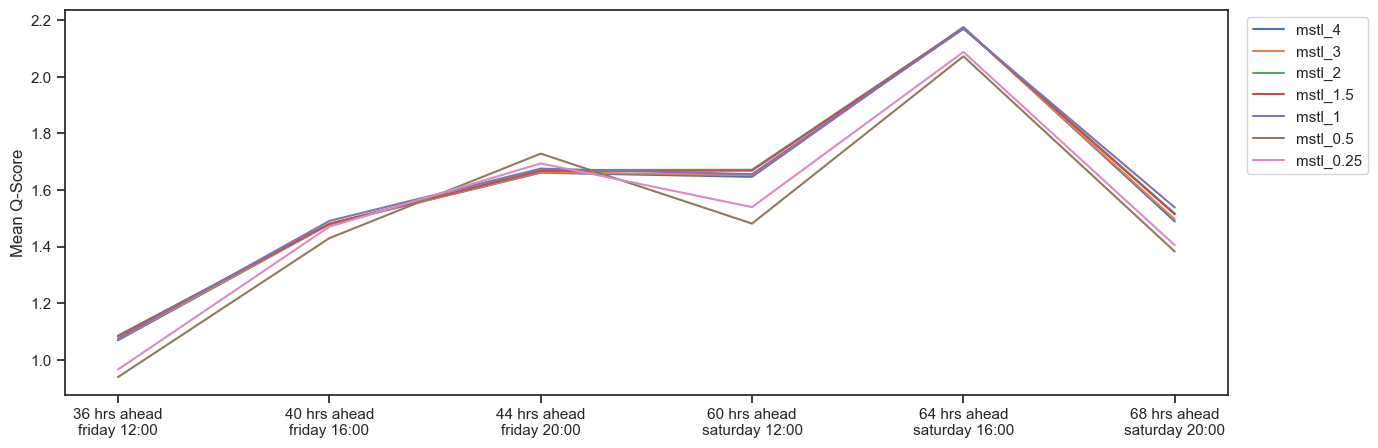

In [202]:
plt.figure(figsize=(15, 5))

# mark fcast dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

for model in all_models:
    model_df = model_avg_scores_entire_period_dict[model].mean(axis=1)
    plt.plot(model_df.index, model_df, label=model)s

# custom xlabels
xlabels = [f'{hor} hrs ahead' for hor in fcast_hor]
labels_add = ['friday 12:00', 'friday 16:00', 'friday 20:00',
              'saturday 12:00', 'saturday 16:00', 'saturday 20:00']
# add labels_add behind xlabels and put \n in between
xlabels = [f'{x}\n{labels_add[i]}' for i, x in enumerate(xlabels)]
plt.xticks(ticks=np.arange(len(fcast_hor)), labels=xlabels)

plt.ylabel('Mean Q-Score')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

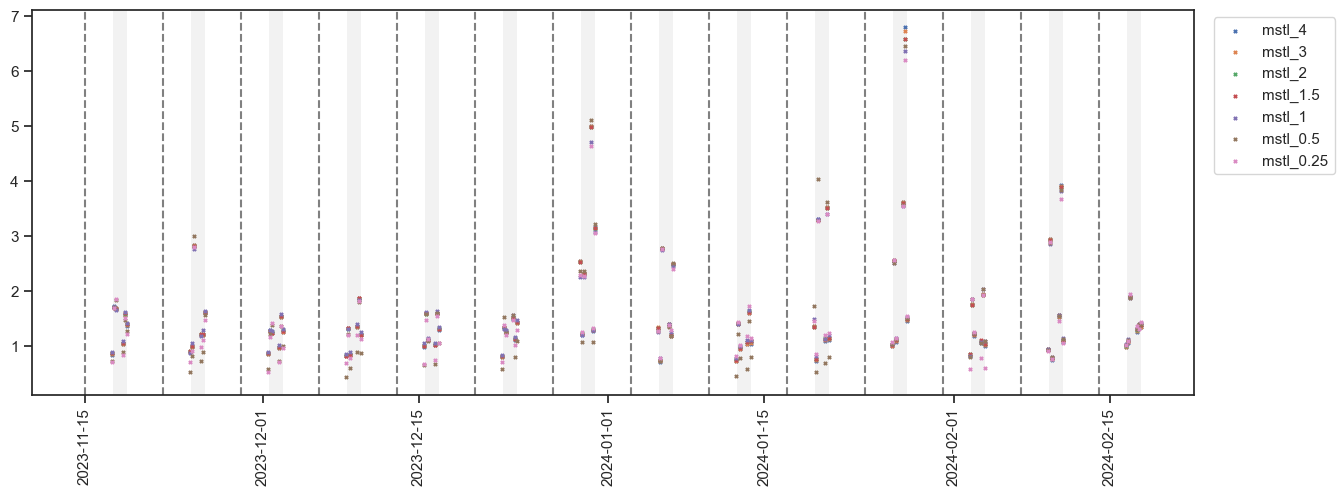

In [188]:
plt.figure(figsize=(15, 5))

# mark fcast dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

for fcast_date in fcast_dates_cet:
    plt.axvline(fcast_date, color='grey', linestyle='--')
    subm_timestamps = [(fcast_date + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
    # highlight are from first subm_timestamp to last subm_timestamp
    plt.axvspan(subm_timestamps[0], subm_timestamps[-1], alpha=0.1, lw=0, color='grey')

for model in all_models:
    model_df = model_scores_entire_period_dict[model].iloc[:,:5].mean(axis=1) # subset qscores only
    plt.scatter(model_df.index, model_df, label=model, s=5, marker='x')
    # plt.plot(model_df.index, model_df, label=model)

# rotate x labels 90 degrees
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

### Ensemble Combination Eval Function ...

In [163]:
def eval_all_ensembles(ens_size, all_models, fcasts_dict_all):

    # Generate all possible combinations
    # ens_size = 1
    combis = list(itertools.combinations(all_models, ens_size))
    # filter out all ensembles with repeating models
    combis = [combi for combi in combis if len(set(combi)) == ens_size]
    print(len(combis))

    # Define the start and end dates
    start_date = pd.Timestamp('2023-11-15')
    end_date = pd.Timestamp('2024-02-14')

    # Generate a list of weekly dates in UTC
    fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()

    if ens_size > 1 : all_combi_names = [f"ens | {', '.join(combi)}" for combi in combis]
    else : all_combi_names = [combi[0] for combi in combis]
    res_dict = {}

    # Iterate over the forecast dates
    for fcast_idx, fcast_date in enumerate(fcast_dates_cet):

        # print('= '*30)
        print(f"Forecasting for week starting from {fcast_date} ...")

        # = = = = = = = = = = = = = 
        # generate prediction timestamps based on t0 = following thursday 00:00
        # = = = = = = = = = = = = = 

        # Calculate the Thursday and Wednesday of the week
        t_wednesday = pd.Timestamp(fcast_date).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize('CET')
        subm_timestamps = [(t_wednesday + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
        # print(f"Submission timestamps = {subm_timestamps[0]} to {subm_timestamps[-1]}")

        weekly_fcasts = fcasts_dict_all[fcast_date]

        # = = = = = = = = = = = = = 
        # Evaluation based on submission timestamps
        # = = = = = = = = = = = = = 

        # get actual values at every submission timestamp
        df_energy_eval = df_energy.loc[df_energy['timestamp_CET'].isin(subm_timestamps)].copy()

        weekly_scores_df = pd.DataFrame(index=all_combi_names,
                                        columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975',
                                                'coverage_50', 'coverage_95', 'mae_q0.5'])

        for combi_idx, combi in enumerate(combis):

            # calculate ensemble between the preds of the models in the current combination
            pred_list = [weekly_fcasts[model] for model in combi]
            new_name = f"ens | {', '.join(combi)}" if ens_size > 1 else combi[0]

            # Ignore timestamp_CET column and take the average of the quantiles
            pred_vals_list = [pred.iloc[:, 1:].copy() for pred in pred_list]

            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].copy()
            ens_pred_df.iloc[:, 1:] = sum(pred_vals_list) / len(pred_vals_list)
            df_scores = model_eval.eval_fcast_qscore(ens_pred_df, df_energy_eval, subm_timestamps, quantiles)

            subm_df = ens_pred_df.loc[ens_pred_df['timestamp_CET'].isin(subm_timestamps)]
            # Save the last row of the scores dataframe to final output
            weekly_scores_df.loc[new_name, 'avg_qscore'] = df_scores.values.mean()
            weekly_scores_df.loc[new_name, 'avg_qscore_0.025'] = df_scores.mean(axis=0).iloc[0]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.25'] = df_scores.mean(axis=0).iloc[1]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.5'] = df_scores.mean(axis=0).iloc[2]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.75'] = df_scores.mean(axis=0).iloc[3]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.975'] = df_scores.mean(axis=0).iloc[4]
            weekly_scores_df.loc[new_name, 'coverage_50'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 2], subm_df.iloc[:, 4]).mean()
            weekly_scores_df.loc[new_name, 'coverage_95'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 1], subm_df.iloc[:, 5]).mean()
            weekly_scores_df.loc[new_name, 'mae_q0.5'] = mean_absolute_error(subm_df['q 0.500'], df_energy_eval['gesamt'])

        res_dict[fcast_date] = weekly_scores_df

    return res_dict


### Single Models

In [166]:
all_models = list(fcasts_dict['2023-11-15'].keys())

res_dict_1 = eval_all_ensembles(1, all_models, fcasts_dict)
res_df_1 = pd.concat(res_dict_1.values())
res_df_1 = res_df_1.groupby(res_df_1.index).mean() # .sort_values(by='avg_qscore', ascending=True)
# export to csv
# res_df_1.to_csv("2024_03_28 single model scores.csv")
display(res_df_1.style.highlight_min(color = 'yellow', axis=0))

7
Forecasting for week starting from 2023-11-15 ...
Forecasting for week starting from 2023-11-22 ...
Forecasting for week starting from 2023-11-29 ...
Forecasting for week starting from 2023-12-06 ...
Forecasting for week starting from 2023-12-13 ...
Forecasting for week starting from 2023-12-20 ...
Forecasting for week starting from 2023-12-27 ...
Forecasting for week starting from 2024-01-03 ...
Forecasting for week starting from 2024-01-10 ...
Forecasting for week starting from 2024-01-17 ...
Forecasting for week starting from 2024-01-24 ...
Forecasting for week starting from 2024-01-31 ...
Forecasting for week starting from 2024-02-07 ...
Forecasting for week starting from 2024-02-14 ...


,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
mstl_0.25,1.527069,0.415804,2.153517,2.630090,2.018548,0.417387,0.571429,1.000000,2630.089741
mstl_0.5,1.505631,0.375250,2.070394,2.622247,2.048833,0.411433,0.511905,0.940476,2622.246608
mstl_1,1.600932,0.482688,2.169246,2.644661,2.220021,0.488046,0.726190,0.988095,2644.660558
mstl_1.5,1.597719,0.477652,2.167447,2.677874,2.196278,0.469344,0.678571,0.988095,2677.874180
mstl_2,1.599772,0.479336,2.169964,2.677874,2.200012,0.471673,0.690476,0.988095,2677.874393
mstl_3,1.589729,0.474607,2.157257,2.677874,2.180266,0.458638,0.678571,0.988095,2677.874364
mstl_4,1.586862,0.473341,2.154337,2.678870,2.173828,0.453936,0.666667,0.988095,2678.869911


#### plot q score / etc over horizons

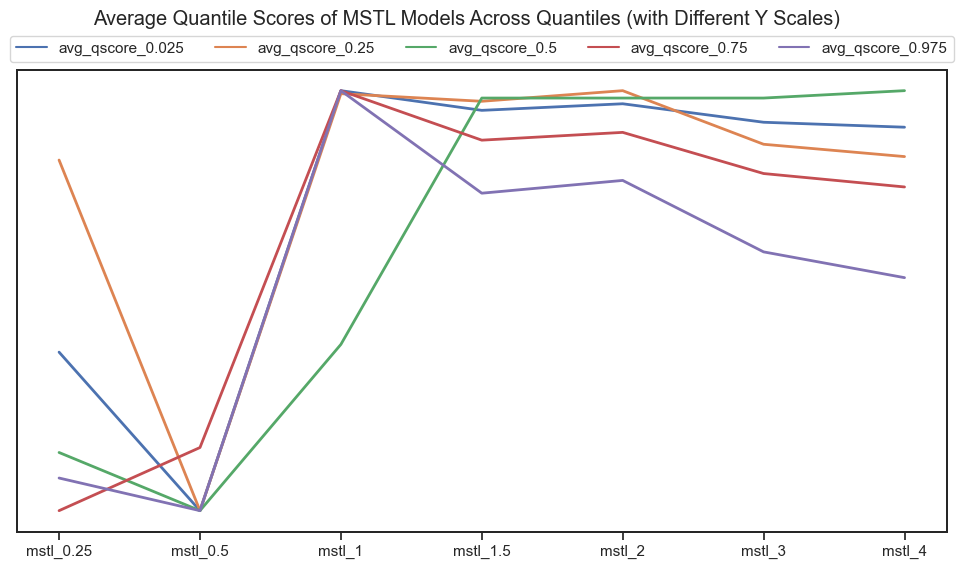

In [76]:
from matplotlib import lines

plt.style.use('default') # default matplotlib style

sns.set_style("whitegrid") # Set Seaborn style and theme
sns.set_theme(style="ticks")

df = res_df_1.copy()
fig, ax = plt.subplots(figsize=(12, 6))
ax.yaxis.set_visible(False)

colors = sns.color_palette()
labels = []
for idx, col in enumerate([col for col in df.columns if 'qscore_' in col]):
    ax2 = ax.twinx() 
    line = ax2.plot(df.index, df[col], c=colors[idx], lw=2)
    labels.append(col)
    # remove y axis
    ax2.yaxis.set_visible(False)

# create manual legend with labels and default colors
ax.legend([lines.Line2D([0], [0], ls='-', c=colors[i]) for i in range(len(labels))], labels, 
          loc='lower center', ncol=5, bbox_to_anchor=(0.5, 1))
plt.suptitle('Average Quantile Scores of MSTL Models Across Quantiles (with Different Y Scales)')
plt.show()

# for col in df.columns:
#     plt.figure(figsize=(12, 2))
#     plt.plot(df.index, df[col])

#     if 'coverage' in col:
#         if '95' in col : plt.axhline(y=0.95, color='r', linestyle='--', label='95%')
#         elif '50' in col: plt.axhline(y=0.5, color='r', linestyle='--', label='50%')

#     plt.title(f"Plot of {col} for MSTL")
#     plt.show()

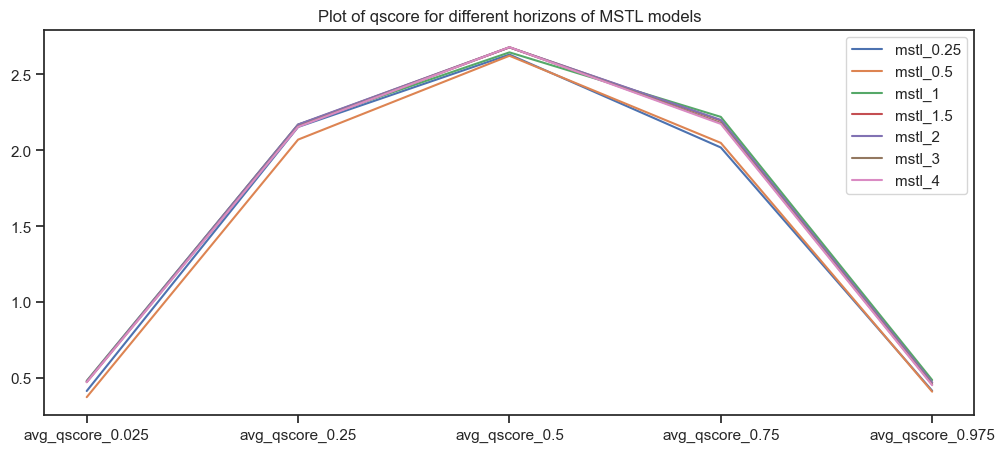

In [80]:
df = res_df_1.copy()

plt.figure(figsize=(12, 5))

for model in df.index:
    plt.plot(df.loc[model].iloc[1:-3], label=model)

plt.legend()
plt.title("Plot of qscore for different horizons of MSTL models")
plt.show()

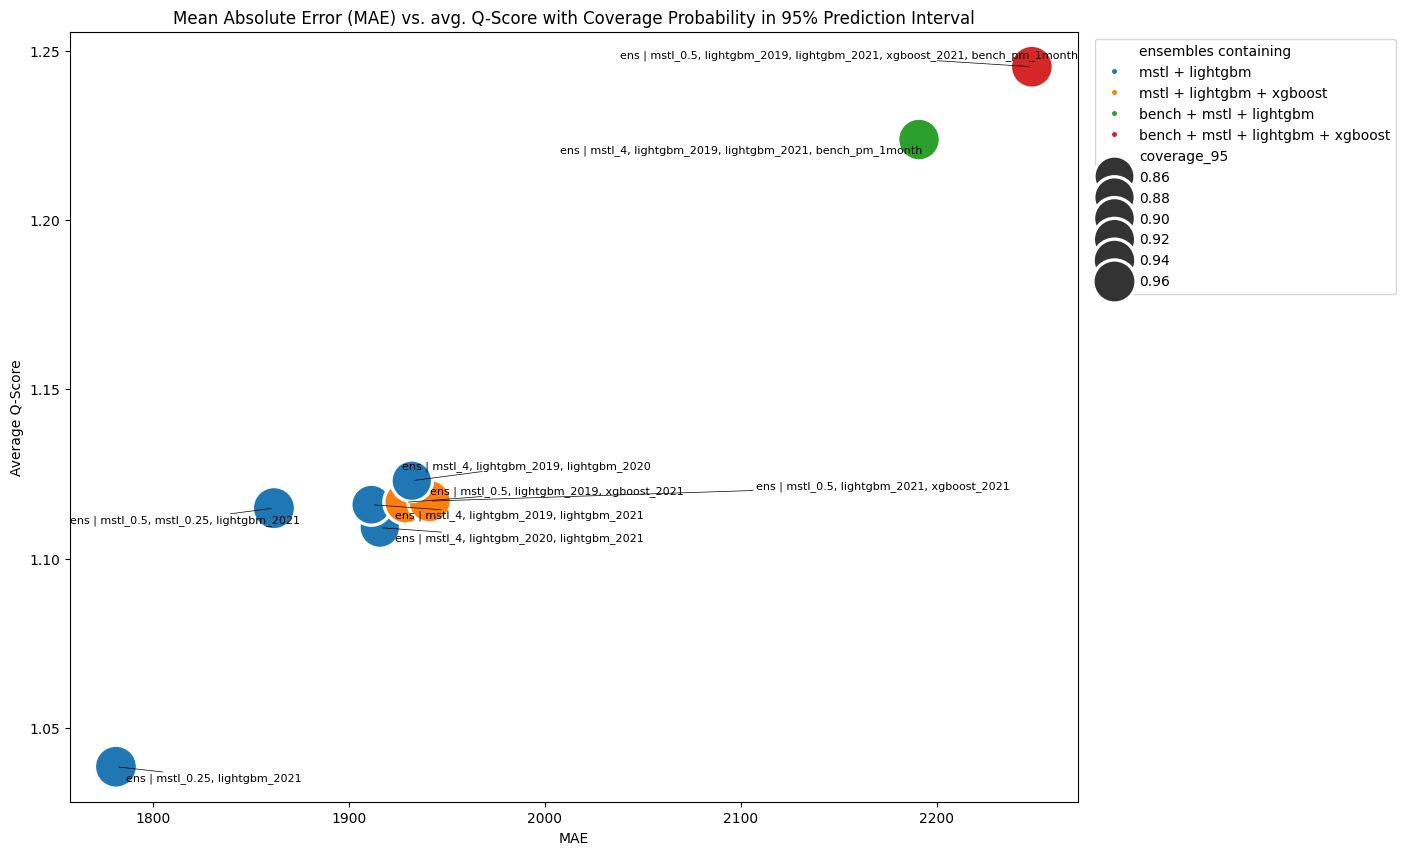

In [24]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_custom.copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

# List of model types
model_types = ['bench', 'mstl', 'lightgbm', 'xgboost', 'grad_boost', 'quant_reg']

# Extract model types from index and create model type column
df['ensembles containing'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('energy_3ens_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()